In [2]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


# Pytorch device specific configuration
# Pytorch Gpu Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [3]:
# import dataset
import pandas as pd

iris = pd.read_csv(
    "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv"
)

# convert from pandas dataframe to tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species == "versicolor"] = 1
labels[iris.species == "virginica"] = 2

In [ ]:
# Batch Size
batch_size = 16
# Use scikit learn train_test_split to split the data
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2
)

# Convert data into pytorch dataset
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Translate train and test data to dataloder objects
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    generator=torch.Generator(device=device),
)
test_loader = DataLoader(
    test_data,
    batch_size=test_data.tensors[0].shape[0],
    generator=torch.Generator(device=device),
)

In [ ]:
# Create the model class
class ANNModelClass(nn.Module):
    def __init__(self, dr):
        super().__init__()

        # Layers
        self.input = nn.Linear(4, 128)
        self.hidden1 = nn.Linear(128, 256)
        self.hidden2 = nn.Linear(256, 128)
        self.output = nn.Linear(128, 3)

        # Parameters
        self.dr = dr

    # forward pass
    def forward(self, x):

        # input Layer
        x = F.relu(self.input(x))
        x = F.dropout(
            x, p=self.dr, training=self.training
        )  # self.training turns off dropout in testing mode

        # Hidden Layer 1
        x = F.relu(self.hidden1(x))
        x = F.dropout(x, p=self.dr, training=self.training)

        # Hidden Layer 2
        x = F.relu(self.hidden2(x))
        x = F.dropout(x, p=self.dr, training=self.training)

        # Output Layer
        x = self.output(x)

        return x

In [8]:
# Test model class
tmpNet = ANNModelClass(0.25)

# Run model on random data
tmpData = torch.randn((50, 4))
yHat = tmpNet(tmpData)  # Let's check for typos in the model code
print(yHat)

tensor([[ 0.0779, -0.0955,  0.0793],
        [ 0.2053, -0.0556,  0.0367],
        [ 0.0915, -0.1141,  0.1121],
        [ 0.1278, -0.0975,  0.0413],
        [ 0.0740, -0.0298,  0.1363],
        [ 0.0827, -0.1502,  0.0666],
        [ 0.1304, -0.0717, -0.0113],
        [ 0.1803, -0.1024,  0.0580],
        [ 0.1130, -0.0839,  0.0511],
        [ 0.1917, -0.1963,  0.0318],
        [ 0.1994, -0.1286,  0.1748],
        [ 0.0398, -0.0935,  0.0718],
        [ 0.1291, -0.0825,  0.0381],
        [ 0.1601, -0.0672,  0.0805],
        [ 0.1375, -0.0632,  0.0330],
        [ 0.1142, -0.1459,  0.0413],
        [ 0.0724, -0.0929,  0.0760],
        [ 0.1375, -0.1028,  0.0460],
        [ 0.1241, -0.1399,  0.0672],
        [ 0.0972, -0.1697,  0.1037],
        [ 0.1357, -0.0033,  0.0322],
        [ 0.1055, -0.0659,  0.1315],
        [ 0.1428, -0.0940,  0.0308],
        [ 0.1638, -0.1404,  0.1196],
        [ 0.1748, -0.1335,  0.1194],
        [ 0.0368,  0.0009,  0.1188],
        [ 0.0758, -0.1276,  0.1598],
 

In [9]:
# Function to create a model
def createNewModel(dr, lr=0.005):
    # Class instance
    ANNIris = ANNModelClass(dr)

    # Loss Function
    lossFun = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.SGD(ANNIris.parameters(), lr=lr)

    return ANNIris, lossFun, optimizer

In [ ]:
# Function to train the model
def trainTheModel(ANNIris, optimizer, lossFun, train_loader, test_loader, nEpochs):

    # Initialize accuricies
    trainAcc = []
    testAcc = []

    # The Loop
    for epoch in range(nEpochs):
        ANNIris.train()  # Training mode

        # Batch accuracy
        batchAcc = []
        for X, y in train_loader:
            # Forward pass
            yHat = ANNIris(X)
            loss = lossFun(yHat, y)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute Batch accuracy
            batchAcc.append(
                100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).item()
            )

        # Train accuracy
        trainAcc.append(np.mean(batchAcc))

        # Test Accuracy
        ANNIris.eval()  # Put model into evalution mode
        X, y = next(iter(test_loader))
        predictables = torch.argmax(ANNIris(X), axis=1)
        testAcc.append(100 * torch.mean((predictables == y).float()).item())

    return trainAcc, testAcc

In [ ]:
# Create a model
dr = 0.0
nEpochs = 500
ANNIris, lossFun, optimizer = createNewModel(dr, lr=0.005)

trainAcc, testAcc = trainTheModel(
    ANNIris, optimizer, lossFun, train_loader, test_loader, nEpochs
)

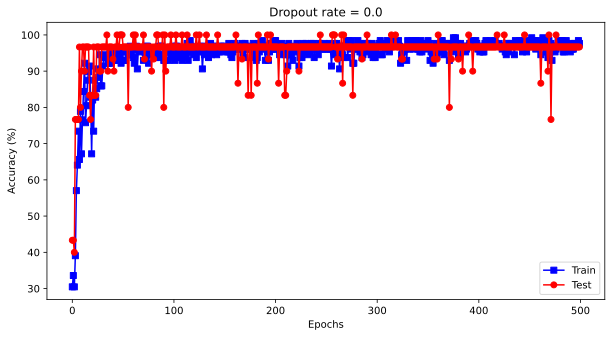

In [ ]:
# Plot the results
fig = plt.figure(figsize=(10, 5))

plt.plot(trainAcc, "bs-")
plt.plot(testAcc, "ro-")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(["Train", "Test"])
plt.title(f"Dropout rate = {dr}")
plt.show()